# Sentiment Analysis on Mask Attituides in US

This notebook uses regex analyzes all the tweets in US from Mar 19 2020 to Mar 09 2021 that contains the topic word 'mask' and analyze the attitudes of these tweets.<br>
To prevent the influence of US election, several terms/phrases related to US elections are used to filtered by regex.<br>
A line graph of the percentage of mask-related 6tweets compare to all tweets in weekly basis would be shown. <br>
The tool vader in nltk package are used to analyze the sentiment(polarity) of the tweets and intends to detect people's attitudes for the mask(pro-mask or anti-mask)<br>
The time series of  the log-value of the postive and negative  mask-related tweets of the entire US are visualized in a time series.<bf>
The scatter plot the log-value ofthe postive and negative mask-related tweets  and the confirmed cases of the entire US are plotted.<br>
Similar scatter plot of several states(CA,NV,OR..) are also plotted and they are used to detect the similariy(regression) betweem the adjacent states.

In [1]:
import pandas as pd
import ast
from textblob import TextBlob
import re
import math
import matplotlib.pyplot as plt
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime
from datetime import timedelta
from matplotlib.pyplot import MultipleLocator

In [2]:
#load dataframe
tws_df = pd.read_csv('tweet_df_loc_total.csv',low_memory=False,lineterminator='\n')

def get_week_index(df):
    return int((df['day_index']-1)/7)
tws_df['week_index']= tws_df.apply(get_week_index,axis = 1)
#remove unnecessary column
tws_df.drop(['lang', 'referenced_tweets','author_id', 'source', 'possibly_sensitive', 'public_metrics','entities', 'context_annotations', 'in_reply_to_user_id', 'attachments'], axis=1, inplace=True)
tws_df.drop(['Unnamed: 0', 'Unnamed: 0.1','geo_x', 'id_y', 'withheld'], axis=1, inplace=True)

In [3]:
#load the us places with the state code
us_pls_df = pd.read_csv("us_places.csv")
us_pls_df.drop(['Unnamed: 0', 'full_name','place_type', 'country_code', 'country','geo','name','Lontitude','Latitude'], axis=1, inplace=True)

In [4]:
total_df = pd.merge(tws_df,us_pls_df,how = 'inner',left_on = 'geo_id',right_on = 'id')
total_df.drop(['place_type', 'country','place_type', 'Lontitude', 'geo_y','Latitude','id'], axis=1, inplace=True)

In [5]:
#text cleaning
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)



#define a function to clean the text
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text)#remove the @
    text = re.sub(r'#','',text) #remove the #
    text = re.sub(r'RT[\s]+','',text) #remove retweet
    text = re.sub(r'https?:\/\/\S+','',text) #remove http 
    text =  re.sub('\n','',text)
    text = re.sub('\S*@\S*\s?', '', text)#remove email
    text = re.sub('\s+', ' ', text)
    text = remove_emoji(text)
    return text

total_df['processed_text'] = total_df['text'].apply(clean_text)

In [6]:
#use regex to clean and filter out the useful info from tweets related to family 
#also filter out the word related to us election
regex_election = re.compile(r'(?i)Trump|Biden|Election|democratic|republican|party|President|campaign|elector|candidate') 
regex_mask = re.compile(r'(?i)mask|Mask')

def mask_related_text(text):
    if regex_mask.search(text):
        return True
    return False

def election_related_text(text):
    if regex_election.search(text):
        return True
    return False

total_df['election_related'] = total_df['processed_text'].apply(election_related_text)
total_df['mask_related'] = total_df['processed_text'].apply(mask_related_text)


In [7]:
mask_related_df = total_df[(total_df["mask_related"]==True)&(total_df["election_related"]==False)]

In [8]:
#using nature language processing tools Vader to seperate the postive and negative tweets of mask
vader = SentimentIntensityAnalyzer()

In [9]:
vader.polarity_scores("I love Data Science")

{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'compound': 0.6369}

In [10]:
#define a function to get the subjectivity and polarity of the twitter
def get_text_polarity(text):
    return vader.polarity_scores(text)['compound']

mask_related_df['text_polarity_value'] = mask_related_df['processed_text'].apply(get_text_polarity)


/tmp/ipykernel_15187/285293844.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mask_related_df['text_polarity_value'] = mask_related_df['processed_text'].apply(get_text_polarity)


In [ ]:
mask_related_df.to_csv('us_df_loc_mask.csv', index=False)

In [11]:
mask_related_df.head(3)

,created_at,text,id_x,geo_id,full_name,country_code,name,day_index,week_index,States,processed_text,election_related,mask_related,text_polarity_value
2,2020-03-19T21:01:51.000Z,You know what we all need during this Corona o...,1240745322952790016,fbd6d2f5a4e4a15e,"California, USA",US,California,1,0,CA,You know what we all need during this Corona o...,False,True,0.0000
293,2020-03-29T05:44:37.000Z,My Father is in china right now and i can’t st...,1244138370915119104,fbd6d2f5a4e4a15e,"California, USA",US,California,11,1,CA,My Father is in china right now and i can’t st...,False,True,0.8928
305,2020-03-30T22:36:27.000Z,It's not extreme til the guy driving next to y...,1244755394041270272,fbd6d2f5a4e4a15e,"California, USA",US,California,12,1,CA,It's not extreme til the guy driving next to y...,False,True,0.0000


In [12]:
#create a data frame that counts the number of tweets in each week
tweets_counts_df = pd.DataFrame()

for i in range(0,50):
    current_mask_df = mask_related_df[mask_related_df['week_index']==i]
    current_df = total_df[total_df['week_index']==i]
    mask_related_tweets_num = len(current_mask_df)
    tweets_num = len(current_df)
    tweets_counts_df = tweets_counts_df.append(pd.Series([int(i), int(tweets_num), int(mask_related_tweets_num)]), ignore_index=True)
                                                     
tweets_counts_df.columns = ['week_index', 'tweets_counts','Mask_related_tweets_counts']
tweets_counts_df['Mask_related_tweets_percentage'] = tweets_counts_df['Mask_related_tweets_counts']/tweets_counts_df['tweets_counts']

In [13]:
#print out the data frame
tweets_counts_df

,week_index,tweets_counts,Mask_related_tweets_counts,Mask_related_tweets_percentage
0,0.0,29305.0,164.0,0.005596
1,1.0,24768.0,182.0,0.007348
2,2.0,17237.0,286.0,0.016592
3,3.0,10616.0,184.0,0.017332
4,4.0,37731.0,721.0,0.019109
5,5.0,45848.0,1037.0,0.022618
6,6.0,44304.0,1174.0,0.026499
7,7.0,44023.0,1213.0,0.027554
8,8.0,67452.0,2233.0,0.033105
9,9.0,68249.0,2718.0,0.039825


Visualize the number of mask-related tweets and pergcentage of the mask-related tweets toward the number of tweets in line graph 

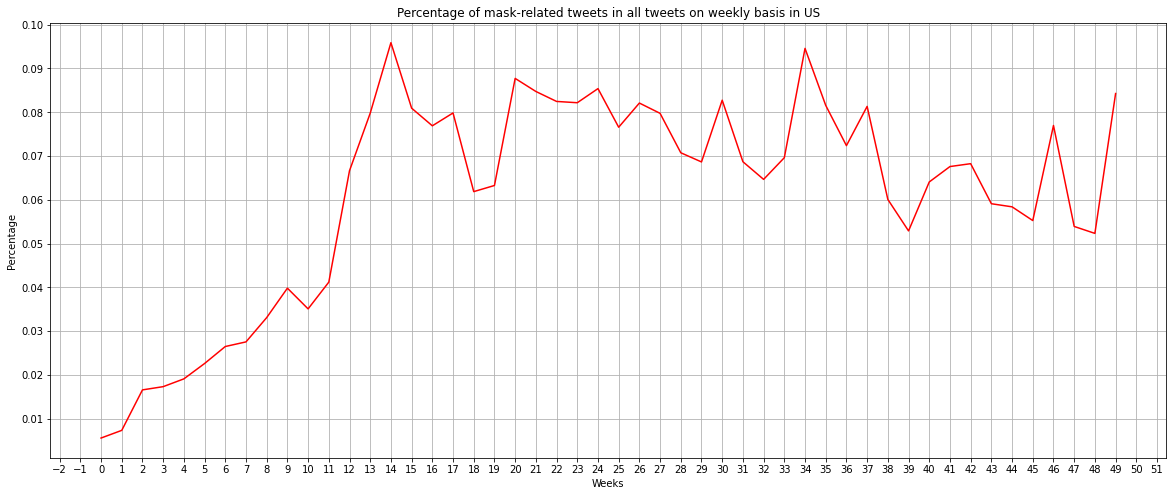

In [15]:
#draw the line graph for the percentage of mask-related tweets change in 
plt.figure(figsize=(20,8))
plt.plot(tweets_counts_df['week_index'],tweets_counts_df['Mask_related_tweets_percentage'],'r')
plt.xlabel('Weeks')
plt.ylabel('Percentage')
plt.grid()
ax=plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.01))
plt.title('Percentage of mask-related tweets in all tweets on weekly basis in US')
plt.show()

Filter out the postive and negative tweets with the value of polarity of texts

In [16]:
pos_mask_related_df = mask_related_df[mask_related_df["text_polarity_value"]>0]
neg_mask_related_df = mask_related_df[mask_related_df["text_polarity_value"]<0]

In [17]:
i = 0
print("Postive Tweets:")
for ind, row in pos_mask_related_df.iterrows():
    if i>15:
        break
    print(i)
    print(row['text'])
    i += 1

Postive Tweets:
0
My Father is in china right now and i can’t stop thinking about him like everyday bc of corona virus! i wanna know how he is, reminding him to wear mask,bring alcohol all the time! He sent me these photos that made me happy tonight! My Coolest Papa is doing good and safe 🙏🏻 💕 https://t.co/9SGIpIEd1K
1
Hidden Smiles #facecovering packaged &amp; ready to ship! DM to order!! #masks #hiddensmiles #facecover #facemasks #facecoverings #mask #coronavirus #COVID__19 #corona #virus #BeatingCorona #cotton #madeinusa https://t.co/KcrT0oxwDl
2
Happy Covid-19 Sunday!  I wear my MASK for you because I talk alot and have very juicy speech!  Another cute mask from Masks for a Cause masksforacause!  They match your purchase and send to front line workers...and… https://t.co/eltROb4nsn
3
I’ll be continuing to #StayAtHome and will still be #SocialDistancing, including wearing a mask to only essential public locations. Even if parts of the #economy reopen, anyone who is at risk for #COVI

In [18]:
i = 0
print("Negative Tweets:")
for ind, row in neg_mask_related_df.iterrows():
    if i>15:
        break
    print(i)
    print(row['text'])
    i += 1

Negative Tweets:
0
In three days I went from “it looks weird to wear a mask,” to “it feels weird to wear a mask,” to “who are those weirdos not wearing masks?”
.
Rona corona maskerona! https://t.co/uGUL10CnpD
1
Protesting the stay at home orders, but they’re wearing masks? Ironic... https://t.co/xIQ2yFSdvp
2
@DamnItRJ This is fake. They’re actually having their workshops create medical masks for medical workers. https://t.co/n438yin83r
3
Day who knows: been lost in animal crossing, making masks, &amp; my @OfficialCricut ... I’m not too upset about that #Quarantine #COVID19 #stayhome
4
What an ass. Regardless of whether he’s tested regularly, at least wear the mask to put people at ease. https://t.co/x5JxZ84QeQ
5
All the idiot needed to do was look around and ask himself “why is everyone wearing a mask except me?” That should have been the hint. #IDidntKnow has been the go to answer when someone from this Admin breaks the law and NOW it’s when going into a hospital without a mask. https

In [19]:
#create a data frame that counts the number of tweets in each week
pos_neg_tweets_counts_df = pd.DataFrame()

for i in range(0,50):
    current_pos_mask_df = pos_mask_related_df[pos_mask_related_df['week_index']==i]
    current_neg_mask_df = neg_mask_related_df[neg_mask_related_df['week_index']==i]
    pos_tweets_num = len(current_pos_mask_df)
    neg_tweets_num = len(current_neg_mask_df)
    pos_neg_tweets_counts_df = pos_neg_tweets_counts_df.append(pd.Series([int(i), int(pos_tweets_num), int(neg_tweets_num)]), ignore_index=True)
                                                     
pos_neg_tweets_counts_df.columns = ['week_index', 'Pos_mask_related_tweets_count','Neg_mask_related_tweets_count']

def get_pos_neg_counts_ratio(df):
    return math.log((df['Pos_mask_related_tweets_count']/df['Neg_mask_related_tweets_count']))


pos_neg_tweets_counts_df['Pos_Neg_counts_log_ratio'] = pos_neg_tweets_counts_df.apply(get_pos_neg_counts_ratio,axis =1)

In [20]:
pos_neg_tweets_counts_df

,week_index,Pos_mask_related_tweets_count,Neg_mask_related_tweets_count,Pos_Neg_counts_log_ratio
0,0.0,82.0,47.0,0.556572
1,1.0,76.0,57.0,0.287682
2,2.0,135.0,77.0,0.561469
3,3.0,71.0,57.0,0.219629
4,4.0,339.0,216.0,0.450722
5,5.0,468.0,316.0,0.392726
6,6.0,550.0,358.0,0.429385
7,7.0,525.0,424.0,0.213665
8,8.0,993.0,762.0,0.264784
9,9.0,1197.0,977.0,0.203087


Visualize the log value of postive tweets/negative tweets counts over time in line graph

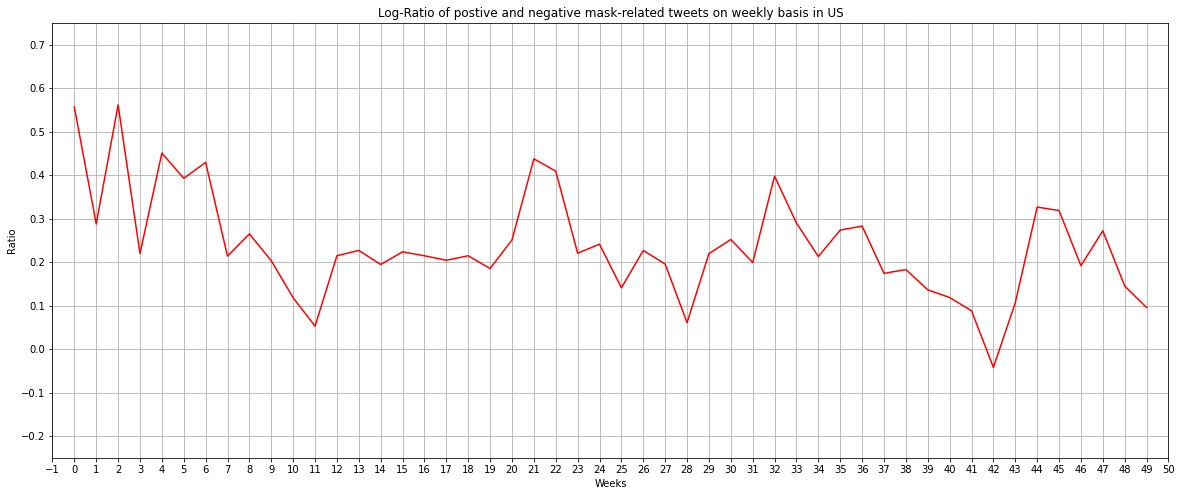

In [21]:
#draw the line graph for the percentage of mask-related tweets change in 
plt.figure(figsize=(20,8))
plt.plot(pos_neg_tweets_counts_df['week_index'],pos_neg_tweets_counts_df['Pos_Neg_counts_log_ratio'],'r')
plt.xlabel('Weeks')
plt.ylabel('Ratio')
plt.ylim([-0.25,0.75])
plt.xlim([-1,50])
plt.grid()
ax=plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
plt.title('Log-Ratio of postive and negative mask-related tweets on weekly basis in US')
plt.show()

Visualize the log value of postive tweets/negative mask-related tweets counts over the new confirmed cases  of US in scatter plot

In [22]:
#read the file of covid data of US 
country_covid_df = pd.read_csv("/home/zhoulita/scratch/covid_19_tweets/international-covid-data.csv",usecols = ['iso_code','date','new_cases'])
country_covid_df['new_cases'].fillna(0)
country_covid_df = country_covid_df[country_covid_df['iso_code']=="USA"]

#remove the date that is out of the bounb 
def check_date_inbound(df):
    start_date = datetime.strptime('2020-03-19', '%Y-%m-%d')
    delta = int((datetime.strptime(df['date'], '%Y-%m-%d')-start_date).days)
    if delta < 0:
        return False
    else:
        return True

country_covid_df['date_inbound'] = country_covid_df.apply(check_date_inbound,axis = 1)
country_covid_df = country_covid_df[country_covid_df['date_inbound'] == True]
del country_covid_df['date_inbound']

#get the week index
def get_week_index(df):
    start_date = datetime.strptime('2020-03-19', '%Y-%m-%d')
    delta = int((datetime.strptime(df['date'], '%Y-%m-%d')-start_date).days)    
    return int(delta/7)

country_covid_df['week_index'] = country_covid_df.apply(get_week_index,axis = 1)
country_covid_df

,iso_code,date,new_cases,week_index
94215,USA,2020-03-19,4494.0,0
94216,USA,2020-03-20,6367.0,0
94217,USA,2020-03-21,5995.0,0
94218,USA,2020-03-22,8873.0,0
94219,USA,2020-03-23,11238.0,0
...,...,...,...,...
94679,USA,2021-06-26,7303.0,66
94680,USA,2021-06-27,3920.0,66
94681,USA,2021-06-28,15083.0,66
94682,USA,2021-06-29,11596.0,66


In [23]:
#get the value of case and death
def get_new_cases_value(df):
    temp_df = country_covid_df[country_covid_df['week_index']==df['week_index']]
    return temp_df['new_cases'].sum()

pos_neg_tweets_counts_df['new_cases'] = pos_neg_tweets_counts_df.apply(get_new_cases_value,axis = 1)

In [24]:
pos_neg_tweets_counts_df

,week_index,Pos_mask_related_tweets_count,Neg_mask_related_tweets_count,Pos_Neg_counts_log_ratio,new_cases
0,0.0,82.0,47.0,0.556572,59668.0
1,1.0,76.0,57.0,0.287682,155750.0
2,2.0,135.0,77.0,0.561469,220214.0
3,3.0,71.0,57.0,0.219629,207849.0
4,4.0,339.0,216.0,0.450722,201694.0
5,5.0,468.0,316.0,0.392726,197556.0
6,6.0,550.0,358.0,0.429385,188946.0
7,7.0,525.0,424.0,0.213665,160898.0
8,8.0,993.0,762.0,0.264784,160166.0
9,9.0,1197.0,977.0,0.203087,147470.0


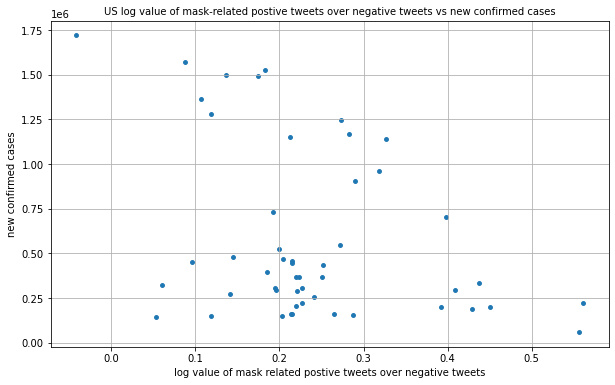

In [25]:
#draw the scatter plot
plt.figure(figsize=(10,6)) 
plt.scatter(pos_neg_tweets_counts_df['Pos_Neg_counts_log_ratio'],pos_neg_tweets_counts_df['new_cases'],s=15)
plt.xlabel('log value of mask related postive tweets over negative tweets')
plt.ylabel('new confirmed cases')
plt.grid()
plt.title('US log value of mask-related postive tweets over negative tweets vs new confirmed cases',fontsize=10)
plt.show()

Visualize the log value of postive tweets/negative mask-related tweets counts over the new confirmed cases and new death of two adjancant<br>
Two adjacant states would be examined which is california and n

In [26]:
# #read the file of covid data in us
covid_states_df = pd.read_csv("/home/zhoulita/scratch/covid_19_tweets/all-states-history.csv",usecols = ['date','state','positiveIncrease'])
covid_states_df['positiveIncrease'].fillna(0)
covid_states_df['date_inbound'] = covid_states_df.apply(check_date_inbound,axis = 1)
covid_states_df = covid_states_df[covid_states_df['date_inbound'] == True]
del covid_states_df['date_inbound']
covid_states_df['week_index'] = covid_states_df.apply(get_week_index,axis = 1)
#remove Hawaii and Alaska from the list
covid_states_df = covid_states_df[(covid_states_df['state']!='AK')&(covid_states_df['state']!='HA')]
covid_states_df 

,date,state,positiveIncrease,week_index
1,2021-03-07,AL,408,50
2,2021-03-07,AR,165,50
3,2021-03-07,AS,0,50
4,2021-03-07,AZ,1335,50
5,2021-03-07,CA,3816,50
...,...,...,...,...
19819,2020-03-19,VT,2,0
19820,2020-03-19,WA,268,0
19821,2020-03-19,WI,53,0
19822,2020-03-19,WV,1,0


In [27]:
#create a data frame that counts the number of tweets in each week in each state
pos_neg_tweets_states_df = pd.DataFrame()

states_list = mask_related_df['States'].unique().tolist()
states_idx = range(len(states_list))

for i in range(0,50):
    for j in states_idx:
        current_state = states_list[j]
        current_df = mask_related_df[(mask_related_df["States"]==current_state)&(mask_related_df["week_index"]==i)]
        pos_tweets_num = len(current_df[current_df['text_polarity_value']>0])
        neg_tweets_num = len(current_df[current_df['text_polarity_value']<0])
        
        pos_neg_tweets_states_df = pos_neg_tweets_states_df.append(pd.Series([int(i),current_state, int(pos_tweets_num), int(neg_tweets_num)]), ignore_index=True)
                                                     
pos_neg_tweets_states_df.columns = ['week_index','state','Pos_mask_related_tweets_count','Neg_mask_related_tweets_count']


In [28]:
#define the function to get log value of the pos/neg tweets
def get_pos_neg_counts_ratio(df):
    if df['Pos_mask_related_tweets_count'] == 0 or df['Neg_mask_related_tweets_count'] ==0:
        return "No"
    return math.log((df['Pos_mask_related_tweets_count']/df['Neg_mask_related_tweets_count']))

pos_neg_tweets_states_df['Pos_Neg_counts_log_ratio'] = pos_neg_tweets_states_df.apply(get_pos_neg_counts_ratio,axis =1)

In [29]:
#define the function to get the current week increase number of confirmed case
def get_state_confirmed_cases(df):
    current_week = df['week_index']
    current_state = df['state']
    covid_week_state_df = covid_states_df[(covid_states_df['week_index']==current_week)&(covid_states_df['state']==current_state)]
    return covid_week_state_df['positiveIncrease'].sum()

pos_neg_tweets_states_df['new_cases'] = pos_neg_tweets_states_df.apply(get_state_confirmed_cases,axis =1)

In [30]:
#remove the log value of not exist
pos_neg_tweets_states_df= pos_neg_tweets_states_df[pos_neg_tweets_states_df['Pos_Neg_counts_log_ratio'] !='No']

In [31]:
pos_neg_tweets_states_df

,week_index,state,Pos_mask_related_tweets_count,Neg_mask_related_tweets_count,Pos_Neg_counts_log_ratio,new_cases
0,0.0,CA,17.0,9.0,0.635989,1744
1,0.0,FL,5.0,3.0,0.510826,1277
2,0.0,TX,7.0,2.0,1.252763,893
4,0.0,GA,3.0,2.0,0.405465,1050
5,0.0,MA,2.0,2.0,0.0,1582
...,...,...,...,...,...,...
2395,49.0,RI,2.0,3.0,-0.405465,2567
2396,49.0,MT,3.0,1.0,1.098612,1109
2397,49.0,WY,3.0,2.0,0.405465,628
2398,49.0,DE,3.0,3.0,0.0,1919


CA


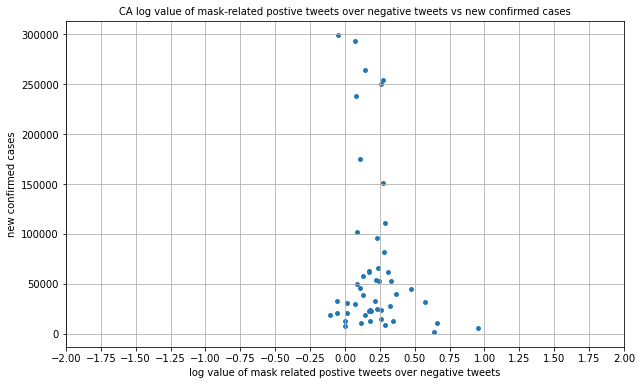

OR


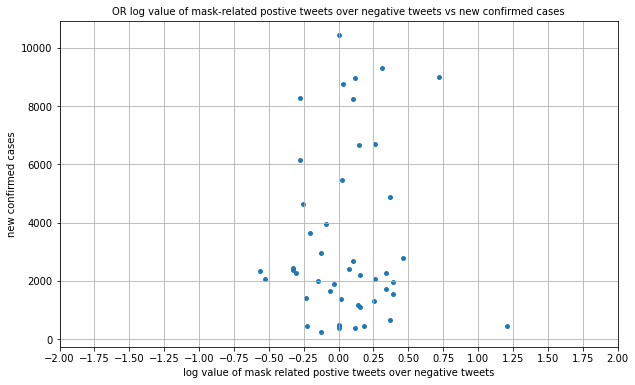

NV


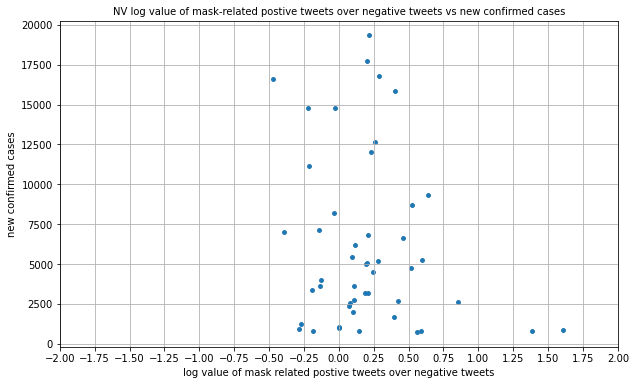

NM


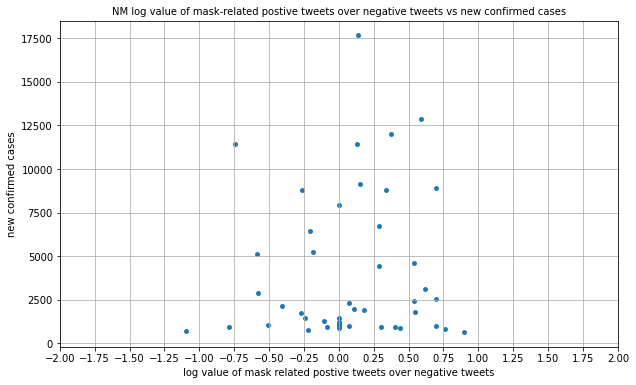

TX


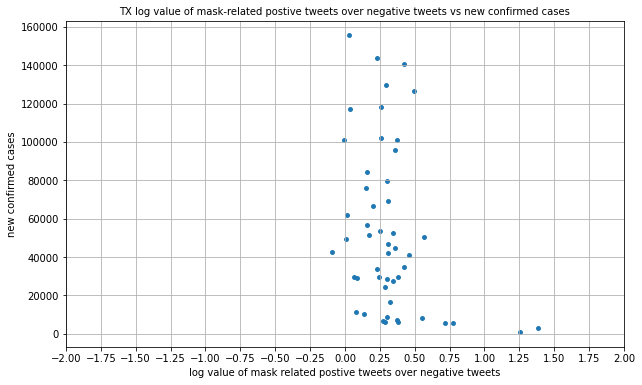

In [32]:
#the state 
i = 0
while i<5:
    state = input()
    df= pos_neg_tweets_states_df[pos_neg_tweets_states_df['state'] ==state]
    plt.figure(figsize=(10,6)) 
    plt.scatter(df['Pos_Neg_counts_log_ratio'],df['new_cases'],s=15)
    plt.xlabel('log value of mask related postive tweets over negative tweets')
    plt.ylabel('new confirmed cases')
    plt.xlim([-2,2])
    ax=plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(0.25))
    plt.grid()
    plt.title(state+' log value of mask-related postive tweets over negative tweets vs new confirmed cases',fontsize=10)
    plt.show()
    i +=1

Since the number of confirmed cases are varied from states to states based on the population, another scatter graph of confirmed cases over population versus the log value of mask related postive tweets over negative tweets

In [33]:
#read the file of population of the states
state_population_df= pd.read_excel("/home/zhoulita/scratch/covid_19_tweets/states_populations.xlsx")
state_population_df.drop(['Unnamed: 3', 'State'], axis=1, inplace=True)

In [34]:
pos_neg_tweets_states_df = pd.merge(pos_neg_tweets_states_df,state_population_df,how = 'inner',left_on = 'state',right_on = 'state_code')

In [37]:
pos_neg_tweets_states_df['New_cases_population_ratio'] = pos_neg_tweets_states_df['new_cases']/pos_neg_tweets_states_df['July_2019_population']

In [38]:
pos_neg_tweets_states_df

,week_index,state,Pos_mask_related_tweets_count,Neg_mask_related_tweets_count,Pos_Neg_counts_log_ratio,new_cases,state_code,July_2019_population,New_cases_population_ratio
0,0.0,CA,17.0,9.0,0.635989,1744,CA,39512223,0.000044
1,1.0,CA,13.0,5.0,0.955511,5800,CA,39512223,0.000147
2,2.0,CA,24.0,18.0,0.287682,8802,CA,39512223,0.000223
3,3.0,CA,20.0,20.0,0.0,7467,CA,39512223,0.000189
4,4.0,CA,66.0,34.0,0.663294,10972,CA,39512223,0.000278
...,...,...,...,...,...,...,...,...,...
2183,45.0,SD,4.0,1.0,1.386294,1031,SD,884659,0.001165
2184,46.0,SD,10.0,3.0,1.203973,941,SD,884659,0.001064
2185,47.0,SD,3.0,3.0,0.0,1105,SD,884659,0.001249
2186,48.0,SD,3.0,2.0,0.405465,1123,SD,884659,0.001269


CA


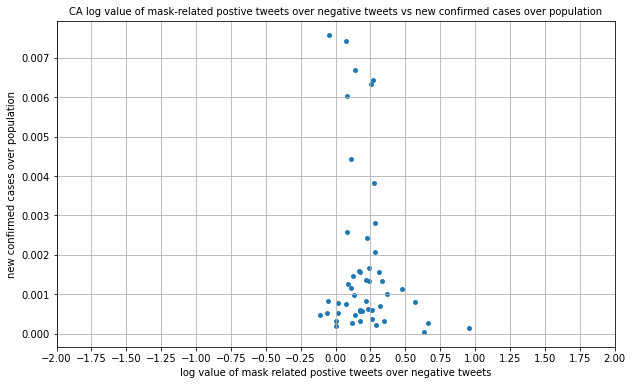

OR


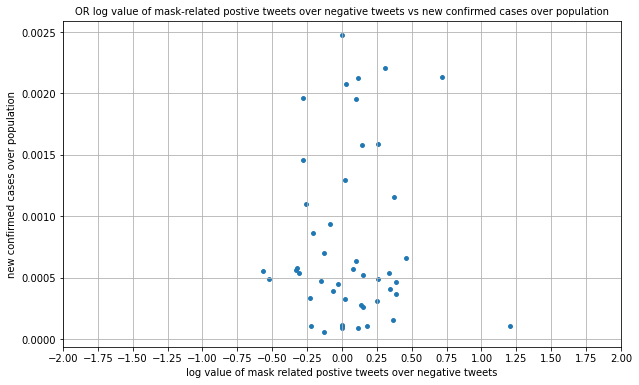

NV


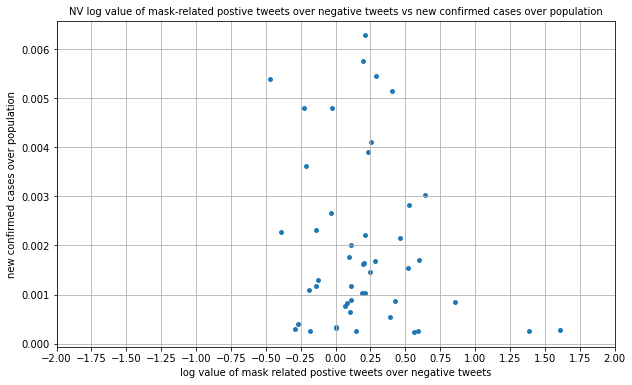

NM


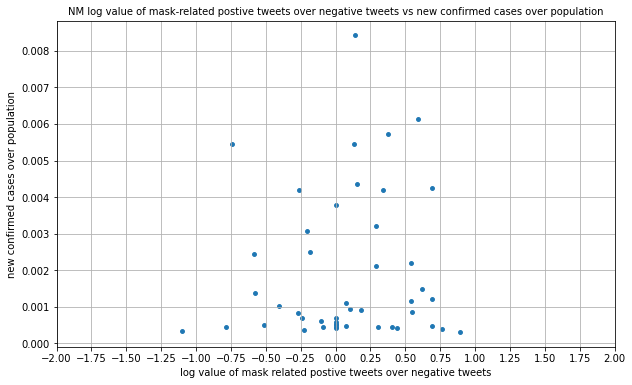

TX


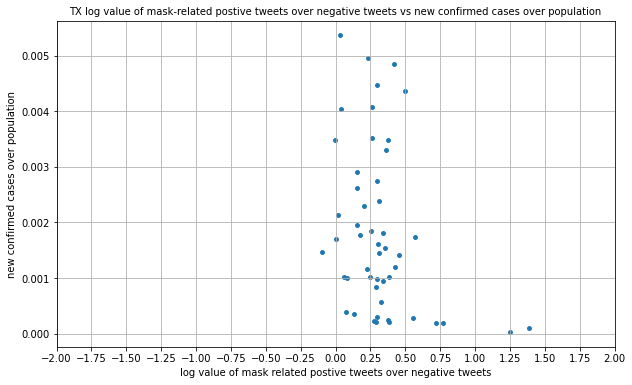

In [42]:
#the state 
i = 0
while i<5:
    state = input()
    df= pos_neg_tweets_states_df[(pos_neg_tweets_states_df['state'] ==state)]
    plt.figure(figsize=(10,6)) 
    plt.scatter(df['Pos_Neg_counts_log_ratio'],df['New_cases_population_ratio'],s=15)
    plt.xlabel('log value of mask related postive tweets over negative tweets')
    plt.ylabel('new confirmed cases over population')
    plt.xlim([-2,2])
    ax=plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(0.25))
    plt.grid()
    plt.title(state+' log value of mask-related postive tweets over negative tweets vs new confirmed cases over population',fontsize=10)
    plt.show()
    i +=1